### Notebook to create a propoer data format to be fed to YOLO v3.
### Notebook is adjusted to original Exact Street 2 Shop dataset

In [1]:
import os
import numpy as np
import glob
import json
from PIL import Image, ImageDraw
import visualize
import pandas as pd

In [2]:
def bbox_coco_to_corners(bbox):
    # Input:
    # [top_left_x, top_left_y, width, height]
    # Output:
    # [top_left_x, top_left_y, bottom_left_x, bottom_left_y]
    bbox[0] = bbox[0]
    bbox[1] = bbox[1]
    bbox[2] = bbox[0] + bbox[2]
    bbox[3] = bbox[1] + bbox[3]

    return bbox


def bbox_coco_to_center(bbox):
    # Input:
    # [top_left_x, top_left_y, width, height]
    # Output:
    # [x_center_of_bbox, y_center_of_bbox, width, height]
    bbox[0] = bbox[0] + bbox[2] / 2
    bbox[1] = bbox[1] + bbox[3] / 2
    bbox[2] = bbox[2]
    bbox[3] = bbox[3]

    return bbox


def bbox_center_to_yolo(bbox, width, height):
    # Input:
    # [x_center_of_bbox, y_center_of_bbox, width, height]
    # Output:
    # [x_center_of_bbox, y_center_of_bbox, width, height] / {image_width || image_height}
    bbox[0] = bbox[0] / width
    bbox[1] = bbox[1] / height
    bbox[2] = bbox[2] / width
    bbox[3] = bbox[3] / height

    return bbox


def bbox_yolo_to_center(bbox, width, height):
    # Input:
    # [x_center_of_bbox, y_center_of_bbox, width, height] / {image_width || image_height}
    # Output:
    # [x_center_of_bbox, y_center_of_bbox, width, height]
    bbox[0] = bbox[0] * width
    bbox[1] = bbox[1] * height
    bbox[2] = bbox[2] * width
    bbox[3] = bbox[3] * height

    return bbox

def bbox_center_to_coco(bbox):
    # Input:
    # [x_center_of_bbox, y_center_of_bbox, width, height]
    # Output:
    # [top_left_x, top_left_y, width, height]
    bbox[0] = bbox[0] - bbox[2] / 2
    bbox[1] = bbox[1] - bbox[3] / 2

    return bbox

def bbox_coco_to_yolo(bbox, width, height):
    # Input:
    # [top_left_x, top_left_y, width, height]
    # Output:
    # [x_center_of_bbox, y_center_of_bbox, width, height] / {image_width || image_height}
    bbox = bbox_coco_to_center(bbox)
    bbox = bbox_center_to_yolo(bbox, width, height)

    return bbox

def bbox_yolo_to_coco(bbox, width, height):
    # Input:
    # [x_center_of_bbox, y_center_of_bbox, width, height] / {image_width || image_height}
    # Output:
    # [top_left_x, top_left_y, width, height]
    bbox = [float(item) for item in bbox]
    bbox = bbox_yolo_to_center(bbox, width, height)
    bbox = bbox_center_to_coco(bbox)
    bbox = [int(item) for item in bbox]

    return bbox

def check_if_file_exist(path):
    return os.path.isfile(path)

def load_json(json_abs_path):
    return json.load(open(json_abs_path))

In [3]:
def remove_corrupted_imgs(working_dir, files):
    from PIL import Image
    for filename in files:
        try:
            img = Image.open(os.path.join(working_dir, filename)) # open the image file
            img.verify()
            cv2.imread((os.path.join(working_dir, filename))).shape
        except:
            print('Deleting ', filename)
            os.system('rm {}'.format(os.path.join(working_dir, filename)))

### Set paths and filesnames

In [4]:
data_dir = '/home/mwieczorek/data/street2shop/meta'
images_dir = '/home/mwieczorek/data/street2shop/images'
save_dir = '/home/mwieczorek/data/street2shop'

# train_filename = 'train_data.txt'
# test_filename = 'test_data.txt'
train_all_filename = 'street2shop_all_coco_format'

#### Create a list of all  images files and their basenames

In [5]:
all_images_list_names = list(map(lambda x : os.path.basename(x), list(glob.glob(os.path.join(images_dir, '*.jpg')))))
# images_basenames = list(map(lambda x : x.rstrip('.jpg'), all_images_list_names))

In [6]:
all_images_list_names[0]

'000402331.jpg'

In [7]:
working_dir = images_dir
files = all_images_list_names

In [8]:
# i = 0
# j = 0

In [9]:
# from PIL import Image
# import cv2
# for filename in files:
#     filename
#     try:
#         img = Image.open(os.path.join(working_dir, filename)) # open the image file
#         img.verify()
#         cv2.imread((os.path.join(working_dir, filename))).shape
#         j += 1
#     except:
#         i += 1
# #         print('Deleting ', filename)
#         os.system('rm {}'.format(os.path.join(working_dir, filename)))
# #         print(os.path.join(working_dir, filename))

In [10]:
# print(j, i)

##### Number of correct images 381848. Number of deleted images: 41428

#### Category name id map

In [11]:
category_name_id_map = {
    'bags': 0,
    'belts' : 1,
    'dresses' : 2,
    'eyewear' : 3,
    'footwear' : 4,
    'hats' : 5,
    'leggings' : 6,
    'outerwear' : 7,
    'pants' : 8,
    'skirts' : 9,
    'tops' : 10,

}

In [12]:
category_id_name_map = {v:k for k,v in category_name_id_map.items()}

### Create images info

In [13]:
def create_image_info(image_id, width, height, file_name, license=0, flickr_url='', coco_url='', data_captured=''):
    image = {
        "id": image_id,
        "file_name": file_name,
        "width": width,
        "height": height,
        "license": license,
        "flickr_url": flickr_url,
        "coco_url": coco_url,
        "date_captured": data_captured
    }

    return image

In [14]:
all_images_paths = glob.glob(os.path.join(images_dir, '*.jpg'))
print(f'Number of found images: {len(all_images_paths)}')

Number of found images: 377120


In [42]:
all_image_info = []
for image_path in all_images_paths:
    file_name = os.path.basename(image_path)
    img_id = int(file_name.strip('.jpg'))
    
    img = Image.open(image_path)
    w, h = img.size
    
    all_image_info.append(create_image_info(image_id=img_id, width=w, height=h, file_name=file_name, license=0, flickr_url='', coco_url='', data_captured=''))

/home/mwieczorek/miniconda3/envs/visual_search/lib/python3.7/site-packages/PIL/Image.py:2735: DecompressionBombWarning: Image size (99272481 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
/home/mwieczorek/miniconda3/envs/visual_search/lib/python3.7/site-packages/PIL/Image.py:2735: DecompressionBombWarning: Image size (109820000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
/home/mwieczorek/miniconda3/envs/visual_search/lib/python3.7/site-packages/PIL/Image.py:2735: DecompressionBombWarning: Image size (123871510 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


In [14]:
# Load earlier processed images info
all_image_info = load_json('./all_images_info.json')

In [15]:
len(all_image_info)

377120

In [16]:
all_image_info[:5]

[{'id': 204812,
  'file_name': '000204812.jpg',
  'width': 1920,
  'height': 2240,
  'license': 0,
  'flickr_url': '',
  'coco_url': '',
  'date_captured': ''},
 {'id': 324219,
  'file_name': '000324219.jpg',
  'width': 2000,
  'height': 2000,
  'license': 0,
  'flickr_url': '',
  'coco_url': '',
  'date_captured': ''},
 {'id': 173594,
  'file_name': '000173594.jpg',
  'width': 1920,
  'height': 1440,
  'license': 0,
  'flickr_url': '',
  'coco_url': '',
  'date_captured': ''},
 {'id': 173616,
  'file_name': '000173616.jpg',
  'width': 1920,
  'height': 1440,
  'license': 0,
  'flickr_url': '',
  'coco_url': '',
  'date_captured': ''},
 {'id': 137732,
  'file_name': '000137732.jpg',
  'width': 870,
  'height': 1110,
  'license': 0,
  'flickr_url': '',
  'coco_url': '',
  'date_captured': ''}]

# Single category at once

In [17]:
def create_annotations(anno_id, image_id, category_id, bbox='', pair_id='', style='', segmentation='', area=0, iscrowd=0):
    annotation = {
        "id": anno_id,
        "image_id": image_id,
        "category_id": category_id,
        "segmentation": segmentation,
        "area": area,
        "bbox": bbox,
        "iscrowd": iscrowd,
        "pair_id": pair_id,
        "style": style
    }
    
    return annotation

In [20]:
anno_id = 0
all_annos = []

category_name = 'tops'
idx = 98
style_idx = idx + 1

train_json = load_json(os.path.join(data_dir,f'train_pairs_{category_name}.json'))
test_json = load_json(os.path.join(data_dir,f'test_pairs_{category_name}.json'))
retrival_json = load_json(os.path.join(data_dir,f'retrieval_{category_name}.json'))

#     retrival_dict_inverse = [{v:k for k,v in item.items()} for item in retrival_json]
# pair_id_mapping = category_name_product_id_unique_pair_id_map[category_name]

In [21]:
#### Try to create a unique pair_id from products and their photos
unique_pair_id = 1
single_category_map_dict = {}

retrival_json = load_json(os.path.join(data_dir,f'retrieval_{category_name}.json'))

for item in retrival_json:
    photo_id = item['photo']
    product_id = item['product']

#     all_shop_products_image_ids.append(photo_id)

    exists = single_category_map_dict.get(product_id, None)

    if exists is None:
        single_category_map_dict[product_id] = unique_pair_id  # Product_id -> unique pair_id
        unique_pair_id += 1
    else:
        continue

In [22]:
max(list(single_category_map_dict.keys()))

38946

In [23]:
train_json[:2]

[{'photo': 17399,
  'product': 9316,
  'bbox': {'width': 751, 'top': 887, 'left': 682, 'height': 772}},
 {'photo': 134,
  'product': 12579,
  'bbox': {'width': 526, 'top': 1260, 'left': 879, 'height': 1175}}]

In [26]:
retrival_json[:2]

[{'photo': 132905, 'product': 1}, {'photo': 158548, 'product': 2}]

In [28]:
retrival_json_inverse_map = {item['product']:item['photo']  for item in retrival_json}

In [36]:
[print(item) for item in retrival_json if item['product'] == 9316]

{'photo': 90071, 'product': 9316}
{'photo': 90072, 'product': 9316}
{'photo': 90073, 'product': 9316}
{'photo': 90074, 'product': 9316}


[None, None, None, None]

In [30]:
for item in train_json:
    photo_id = item.get('photo')
    bbox_temp = item.get('bbox')
    bbox = [bbox_temp['left'], bbox_temp['top'], bbox_temp['width'], bbox_temp['height']]

    product_id = item['product']
#         pair_id = retrival_json[product_id+1]['photo']  # Products ids are sorted in a list, but they start from 1 not from 0.  # This completly wrong, as based on false assumption
    pair_id = retrival_json_inverse_map[int(product_id)]
#     pair_id = pair_id_mapping[product_id]

    all_annos.append(create_annotations(anno_id=anno_id, image_id=photo_id, category_id=idx, bbox=bbox, pair_id=pair_id, style=style_idx))
    anno_id += 1

In [32]:
all_annos[:2]

[{'id': 0,
  'image_id': 17399,
  'category_id': 98,
  'segmentation': '',
  'area': 0,
  'bbox': [682, 887, 751, 772],
  'iscrowd': 0,
  'pair_id': 90074,
  'style': 99},
 {'id': 1,
  'image_id': 134,
  'category_id': 98,
  'segmentation': '',
  'area': 0,
  'bbox': [879, 1260, 526, 1175],
  'iscrowd': 0,
  'pair_id': 63067,
  'style': 99}]

In [ ]:
for item in test_json:
    photo_id = item.get('photo')
    bbox_temp = item.get('bbox')
    bbox = [bbox_temp['left'], bbox_temp['top'], bbox_temp['width'], bbox_temp['height']]

    product_id = item['product']
#         pair_id = retrival_json[product_id+1]['photo']  # Products ids are sorted in a list, but they start from 1 not from 0.
    pair_id = pair_id_mapping[product_id]

    all_annos.append(create_annotations(anno_id=anno_id, image_id=photo_id, category_id=idx, bbox=bbox, pair_id=pair_id, style=style_idx))
    anno_id += 1

#     break

# Single category at once end ^^^
### ==============================================

# All categories at once

#### How to solve unique product ids (from retrival jsons) that are only unique WITHIN a category, but not globally.
## All steps are for a single category
1. Take train json 
2. Take retrival file
3. From train:
    photo is just an int of file_name
    produt is product id which is a pair_id. Problem: It is uniue only within a category
        Product needes to be remaped using retrival json so that the pair_id == photo id of a product.
        Moreove style number should also be given >=1
            For now, the style number will be probably done as (category_id + 1) so to ensure that if 
            on one photo there are more than 1 product they should have unique style ids

In [47]:
train_jsons_list = sorted(glob.glob(os.path.join(data_dir, 'train_*.json')))

In [48]:
load_json(train_jsons_list[0])[10]

{'photo': 7028,
 'product': 7697,
 'bbox': {'width': 545, 'top': 1595, 'height': 690, 'left': 70}}

In [77]:
def create_annotations(anno_id, image_id, category_id, bbox='', pair_id='', style='', segmentation='', area=0, iscrowd=0):
    annotation = {
        "id": anno_id,
        "image_id": image_id,
        "category_id": category_id,
        "segmentation": segmentation,
        "area": area,
        "bbox": bbox,
        "iscrowd": iscrowd,
        "pair_id": pair_id,
        "style": style
    }
    
    return annotation

In [78]:
### Create pair_ids map to map ALL products to a single unique pair_id

category_name_product_id_unique_pair_id_map = {}
all_shop_products_image_ids = []

unique_pair_id = 1
for idx, category_name in enumerate(category_name_id_map):
    print(category_name)
    single_category_map_dict = {}
    
    retrival_json = load_json(os.path.join(data_dir,f'retrieval_{category_name}.json'))
    
    for item in retrival_json:
        photo_id = item['photo']
        product_id = item['product']
        
        all_shop_products_image_ids.append(photo_id)
        
        exists = single_category_map_dict.get(product_id, None)
        
        if exists is None:
            single_category_map_dict[product_id] = unique_pair_id
            unique_pair_id += 1
        else:
            continue
        
    category_name_product_id_unique_pair_id_map[category_name] = single_category_map_dict

bags
belts
dresses
eyewear
footwear
hats
leggings
outerwear
pants
skirts
tops


In [79]:
unique_pair_id_product_id_map = {}
for idx, category_name in enumerate(category_name_id_map):
    temp = category_name_product_id_unique_pair_id_map[category_name]
    temp = {v:k for k,v in temp.items()}
    unique_pair_id_product_id_map[category_name] = temp

In [80]:
import collections
print([item for item, count in collections.Counter(all_shop_products_image_ids).items() if count > 1])

[174488, 118459, 94045, 253790, 176630, 121392, 117011, 228594, 118278, 319652, 116745, 171751, 171750, 95565, 118437, 42920, 72432, 163831, 163845, 163857, 163856, 112083, 334499, 334501, 47755, 67524, 92483, 92482, 362886, 209393, 71402, 115808, 115414, 171197, 354390, 114563, 93518, 93517, 209302, 79996, 96123, 210269, 93107, 69963, 69964, 163937, 163836, 95549, 95548, 92275, 289636, 115842, 94666, 94667, 163717, 163666, 163665, 163661, 209297, 95263, 209350, 163971, 95769, 120737, 163753, 209887, 212148, 164064, 164055, 164060, 164058, 164059, 163868, 67642, 67641, 66385, 192763, 192769, 116066, 194051, 194053, 334091, 163911, 163908, 115427, 93547, 93545, 68815, 68817, 115291, 115292, 114803, 114625, 95361, 95218, 210559, 210558, 164850, 164854, 164844, 164849, 77059, 76265, 164154, 164155, 42919, 41159, 19176, 164050, 115159, 118514, 113854, 121088, 95638, 95639, 118843, 72210, 72211, 197185, 197186, 111464, 120212, 210449, 346760, 209286, 68131, 164237, 190899, 189768, 98423, 11

In [81]:
for idx, category_name in enumerate(category_name_id_map):
    
    retrival_json = load_json(os.path.join(data_dir,f'retrieval_{category_name}.json'))
    
    for item in retrival_json:
        if item['photo'] == 94045:
            print(category_name, item)

bags {'photo': 94045, 'product': 775}
bags {'photo': 94045, 'product': 1991}


In [82]:
for idx, category_name in enumerate(category_name_id_map):
    
    retrival_json = load_json(os.path.join(data_dir,f'retrieval_{category_name}.json'))
    
    for item in retrival_json:
        if item['product'] == 1991:
            print(category_name, item)

bags {'photo': 94045, 'product': 1991}
dresses {'photo': 233379, 'product': 1991}
dresses {'photo': 233380, 'product': 1991}
footwear {'photo': 203149, 'product': 1991}
leggings {'photo': 209295, 'product': 1991}
leggings {'photo': 209296, 'product': 1991}
outerwear {'photo': 369330, 'product': 1991}
outerwear {'photo': 369331, 'product': 1991}
pants {'photo': 101384, 'product': 1991}
pants {'photo': 101385, 'product': 1991}
pants {'photo': 101387, 'product': 1991}
pants {'photo': 101386, 'product': 1991}
skirts {'photo': 132075, 'product': 1991}
tops {'photo': 423295, 'product': 1991}


In [83]:
# category_name_product_id_unique_pair_id_map['tops']

In [84]:
unique_pair_id

204796

In [85]:
anno_id = 0
all_annos = []

for idx, category_name in enumerate(category_name_id_map):
    style_idx = idx + 1
    
    train_json = load_json(os.path.join(data_dir,f'train_pairs_{category_name}.json'))
    test_json = load_json(os.path.join(data_dir,f'test_pairs_{category_name}.json'))
#     retrival_json = load_json(os.path.join(data_dir,f'retrieval_{category_name}.json'))
    
#     retrival_dict_inverse = [{v:k for k,v in item.items()} for item in retrival_json]
    pair_id_mapping = category_name_product_id_unique_pair_id_map[category_name]
    
    for item in train_json:
        photo_id = item.get('photo')
        bbox_temp = item.get('bbox')
        bbox = [bbox_temp['left'], bbox_temp['top'], bbox_temp['width'], bbox_temp['height']]
        
        product_id = item['product']
#         pair_id = retrival_json[product_id+1]['photo']  # Products ids are sorted in a list, but they start from 1 not from 0.  # This completly wrong, as based on false assumption
        pair_id = pair_id_mapping[product_id]
    
        all_annos.append(create_annotations(anno_id=anno_id, image_id=photo_id, category_id=idx, bbox=bbox, pair_id=pair_id, style=style_idx))
        anno_id += 1
        
    for item in test_json:
        photo_id = item.get('photo')
        bbox_temp = item.get('bbox')
        bbox = [bbox_temp['left'], bbox_temp['top'], bbox_temp['width'], bbox_temp['height']]
        
        product_id = item['product']
#         pair_id = retrival_json[product_id+1]['photo']  # Products ids are sorted in a list, but they start from 1 not from 0.
        pair_id = pair_id_mapping[product_id]
    
        all_annos.append(create_annotations(anno_id=anno_id, image_id=photo_id, category_id=idx, bbox=bbox, pair_id=pair_id, style=style_idx))
        anno_id += 1
print(f'Number of all annotations from the original dataset: {len(all_annos)}')
#     break

Number of all annotations from the original dataset: 39266


In [86]:
pair_id_mapping[9316]

175165

In [91]:
[item for item in all_annos if item['pair_id'] == 175165]

[{'id': 36330,
  'image_id': 17399,
  'category_id': 10,
  'segmentation': '',
  'area': 0,
  'bbox': [682, 887, 751, 772],
  'iscrowd': 0,
  'pair_id': 175165,
  'style': 11},
 {'id': 392093,
  'image_id': 90071,
  'category_id': 10,
  'segmentation': '',
  'area': 0,
  'bbox': '',
  'iscrowd': 0,
  'pair_id': 175165,
  'style': 11},
 {'id': 392094,
  'image_id': 90072,
  'category_id': 10,
  'segmentation': '',
  'area': 0,
  'bbox': '',
  'iscrowd': 0,
  'pair_id': 175165,
  'style': 11},
 {'id': 392095,
  'image_id': 90073,
  'category_id': 10,
  'segmentation': '',
  'area': 0,
  'bbox': '',
  'iscrowd': 0,
  'pair_id': 175165,
  'style': 11},
 {'id': 392096,
  'image_id': 90074,
  'category_id': 10,
  'segmentation': '',
  'area': 0,
  'bbox': '',
  'iscrowd': 0,
  'pair_id': 175165,
  'style': 11}]

#### Trying to continue the annotations also for shop-taken images

In [89]:
# all_annos = []

for idx, category_name in enumerate(category_name_id_map):
    style_idx = idx + 1
    
#     train_json = load_json(os.path.join(data_dir,f'train_pairs_{category_name}.json'))
#     test_json = load_json(os.path.join(data_dir,f'test_pairs_{category_name}.json'))
    retrival_json = load_json(os.path.join(data_dir,f'retrieval_{category_name}.json'))
    
#     retrival_dict_inverse = [{v:k for k,v in item.items()} for item in retrival_json]
    pair_id_mapping = category_name_product_id_unique_pair_id_map[category_name]  # Maps orignal product id to the new unique pair_id
    
    for item in retrival_json:
        photo_id = item.get('photo')
        product_id = item['product']
#         pair_id = retrival_json[product_id+1]['photo']  # Products ids are sorted in a list, but they start from 1 not from 0.
        pair_id = pair_id_mapping[product_id]
    
        all_annos.append(create_annotations(anno_id=anno_id, image_id=photo_id, category_id=idx, bbox='', pair_id=pair_id, style=style_idx))
        
        anno_id += 1

In [90]:
print(f'Number of all annotations including pack shots from stores: {len(all_annos)}')

Number of all annotations including pack shots from stores: 444163


# All category at once end ^^^

In [97]:
images_paths_list = [item['file_name'] for item in all_image_info]

In [110]:
existing_images_list = []
non_exisiting_images_list = []

In [111]:
for img in images_paths_list:
    img = os.path.join(images_dir, img)
    if os.path.exists(img):
        existing_images_list.append(img)
    else:
        non_exisiting_images_list.append(img)
#         print(f'Image does not exisit {img}')
print(f'Number of exisiting images in JSON: {len(existing_images_list)}')
print(f'Number of non-exisiting images in JSON: {len(non_exisiting_images_list)}')

Number of exisiting images in JSON: 377120
Number of non-exisiting images in JSON: 0


In [114]:
grey_scale_images_to_remove = []
for path in existng_images_list:
    from PIL import Image
#     path = os.path.splitext(path)[0] + '.jpg'
    img = Image.open(path)
    if img.mode == 'L':
#         print(path)
        grey_scale_images_to_remove.append(path)

/home/mwieczorek/miniconda3/envs/visual_search/lib/python3.7/site-packages/PIL/Image.py:2735: DecompressionBombWarning: Image size (99272481 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
/home/mwieczorek/miniconda3/envs/visual_search/lib/python3.7/site-packages/PIL/Image.py:2735: DecompressionBombWarning: Image size (109820000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
/home/mwieczorek/miniconda3/envs/visual_search/lib/python3.7/site-packages/PIL/Image.py:2735: DecompressionBombWarning: Image size (123871510 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


In [115]:
grey_scale_images_to_remove

['/mnt/mwieczorek/street2shop/images/000164016.jpg',
 '/mnt/mwieczorek/street2shop/images/000162376.jpg',
 '/mnt/mwieczorek/street2shop/images/000176610.jpg',
 '/mnt/mwieczorek/street2shop/images/000336431.jpg',
 '/mnt/mwieczorek/street2shop/images/000164015.jpg',
 '/mnt/mwieczorek/street2shop/images/000211918.jpg',
 '/mnt/mwieczorek/street2shop/images/000163625.jpg',
 '/mnt/mwieczorek/street2shop/images/000164529.jpg',
 '/mnt/mwieczorek/street2shop/images/000163668.jpg',
 '/mnt/mwieczorek/street2shop/images/000164466.jpg']

In [21]:
for filename in grey_scale_images_to_remove:
    filename = os.path.splitext(filename)[0]
    filename_txt = filename + '.txt'
    filename_img = filename + '.jpg'
    os.system(f'rm {filename_txt}')
    os.system(f'rm {filename_img}')

In [ ]:
## 

### Bboxes processing

In [22]:
categories_list = []
for item in train_jsons_list:
    categories_list.append(os.path.basename(item).split('.')[0].split('_')[-1])

labels = [1, 2, 6, 7, 4, 12, 14, 5, 8, 11, 9]

categories = dict(zip(categories_list, labels))

In [23]:
categories

{'bags': 1,
 'belts': 2,
 'dresses': 6,
 'eyewear': 7,
 'footwear': 4,
 'hats': 12,
 'leggings': 14,
 'outerwear': 5,
 'pants': 8,
 'skirts': 11,
 'tops': 9}

In [24]:
annotations = {}
json_sub_list = [train_jsons_list, test_jsons_list]
data_type = ['train', 'test']
missing_images = []

In [25]:
for idx, file in enumerate(json_sub_list):
    dataset_type = data_type[idx]
#     print(file)
    temp_list = []
    for jsonn_path in file:
        print(jsonn_path)
        jsonn = load_json(jsonn_path)
        category_name = os.path.basename(jsonn_path).split('.')[0].split('_')[-1]
        category = categories[category_name]
        print(f'Category_name {category_name}, category label {category}')
        
        for item in jsonn:
            photo_id = item.get('photo')
            bbox_temp = item.get('bbox')

            bbox = [bbox_temp['left'], bbox_temp['top'], bbox_temp['width'], bbox_temp['height']]
            
            img_path = os.path.join(images_dir, str(photo_id).zfill(9) + '.jpg')
            try:
                image_size = Image.open(img_path).size
            except:
#                 print(f'Image {photo_id} not found')
                missing_images.append(str(photo_id).zfill(9))
                continue
        
            bbox = bbox_coco_to_yolo(bbox=bbox, width=image_size[0], height=image_size[1])
            
            with open(os.path.join(images_dir, str(photo_id).zfill(9) + '.txt'), 'a') as f:
                f.write('{} {} {} {} {} \n'.format(category, *bbox))

/home/mwieczorek/visual_search/yolo/data/street2shop/meta/train_pairs_bags.json
Category_name bags, category label 1
/home/mwieczorek/visual_search/yolo/data/street2shop/meta/train_pairs_belts.json
Category_name belts, category label 2
/home/mwieczorek/visual_search/yolo/data/street2shop/meta/train_pairs_dresses.json
Category_name dresses, category label 6
/home/mwieczorek/visual_search/yolo/data/street2shop/meta/train_pairs_eyewear.json
Category_name eyewear, category label 7
/home/mwieczorek/visual_search/yolo/data/street2shop/meta/train_pairs_footwear.json
Category_name footwear, category label 4
/home/mwieczorek/visual_search/yolo/data/street2shop/meta/train_pairs_hats.json
Category_name hats, category label 12
/home/mwieczorek/visual_search/yolo/data/street2shop/meta/train_pairs_leggings.json
Category_name leggings, category label 14
/home/mwieczorek/visual_search/yolo/data/street2shop/meta/train_pairs_outerwear.json
Category_name outerwear, category label 5
/home/mwieczorek/visua

In [26]:
np.save(os.path.join(data_dir, 'missing_images_ids.npy'), missing_images)

### Checking correctness of bboxes 

In [18]:
def load_image(img_path):
    return Image.open(img_path)


def draw_bboxes_on_image(image, all_bboxes):
    draw = ImageDraw.Draw(image)
    try:
        len(all_bboxes[0])
        for bbox in all_bboxes:
            bbox = bbox_coco_to_corners(bbox)
            draw.rectangle(bbox)
    except:
        bbox = bbox_coco_to_corners(all_bboxes)
        draw.rectangle(bbox)
    return image

def load_image_and_draw_bbox(img_path, all_bboxes):
    image = load_image(img_path=img_path)
    return draw_bboxes_on_image(image, all_bboxes)

In [19]:
with open(os.path.join(data_dir, train_all_filename), 'r') as f:
    lines = f.readlines()
    lines = [item.strip() for item in lines]

FileNotFoundError: [Errno 2] No such file or directory: '/home/mwieczorek/data/street2shop/meta/street2shop_all_coco_format'

In [29]:
all_street_images_paths = lines

In [30]:
img_id = 213  # from 0 to len(all_street_images_paths)-1 

image_to_plot_path = all_street_images_paths[img_id].replace('txt', 'jpg')

image_annotation_filename = os.path.basename(image_to_plot_path).rstrip('.jpg') + '.txt'

image_annotation_path = os.path.join(images_dir, image_annotation_filename)

with open(image_annotation_path) as f:
    annos = f.readlines()
    annos = [item.strip() for item in annos]
    annos = [item.split(' ') for item in annos]

bbox = [item[1:] for item in annos]
bbox = [[float(item) for item in listt] for listt in bbox]
category = [item[0] for item in annos]

# # Checking if there is any annotation about skirt for the image 000002281.jpg.
# # Checked both train and test, but nothing was found
# json_check = load_json(os.path.join(data_dir, 'train_pairs_dresses.json'))
# photo_id = image_annotation_filename.lstrip('0').rstrip('.txt')
# for idx, item in enumerate(json_check):
#     if str(item['photo']) == photo_id:
#         print(idx)



image = Image.open(image_to_plot_path)
image_size = image.size

bboxes = []
for item in bbox:
    bboxes.append(bbox_coco_to_corners(bbox_yolo_to_coco(bbox=item, width=image_size[0], height=image_size[1])))

bboxes_to_plot  = []
for bbox in bboxes:
    x1,y1,x2,y2 = bbox
    bboxes_to_plot.append([y1,x1,y2,x2])

bbox_plot = np.array(bboxes_to_plot)
category_plot = np.array(category)
image_array = np.array(image)

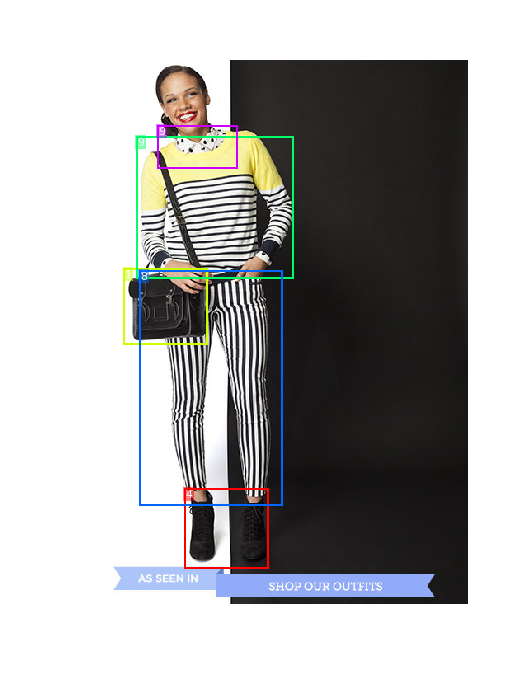

In [31]:
visualize.draw_boxes(image=image_array, boxes=None, refined_boxes=bbox_plot,
               masks=None, captions=category_plot, visibilities=None,
               title="", ax=None)